# CNN, Maxpooling, 3LayerConvNet

https://cs231n.github.io/optimization-2/

https://cs231n.github.io/convolutional-networks/

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from cs231n.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient


def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

---
# Convolution: Naive forward pass

아래 코드는 `cs231n 2020 assignment2`를 참고하여 작성되었습니다.

## Summary of Convolution

- **5x5 Image**
- **3x3 Kernel** 
- **1 padding**
- **1 stride**
![01.gif](img/01.gif)


## Padding

convolution 연산에 의한 Output은 Input과 비교하여 크기가 줄어들게 된다. 

이를 방지하기 위해, Input의 크기를 늘려주는 padding을 하는데 보통 0으로 채워주는 zero padding을 많이 사용한다.

numpy의 pad 함수를 이용하면 쉽게 구현할 수 있다.

[numpy.pad](https://numpy.org/doc/stable/reference/generated/numpy.pad.html) 참고

### numpy.pad(array, pad_width, mode='constant', **kwargs) 사용법

원하는 차원의 위치에 원하는 pad값을 위,아래로 구분하여 pad_width에 넣어주면 된다.

ex) 32,32,3 -> 36,36,3 을 원한다면 pad_width = ((2,2),(2,2),(0,0)) 을 넣어주면 된다.


In [2]:
''' 시각화를 위한 함수 : img_3Dshow(img) '''
def img_3Dshow(img):
    fig = plt.figure(figsize=(5,5))
    
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title("img shape :"+str(img.shape))
    X, Y = np.meshgrid(np.arange(img.shape[1]+1), np.arange(img.shape[0]+1))
    for c in range(img.shape[2]):
        Z = (c+1)*10*np.ones(X.shape)
        ax.plot_surface(X,Y,Z, rstride=1, cstride=1,facecolors=plt.cm.gray(img[:,:,c]))
        
    plt.show()

original img


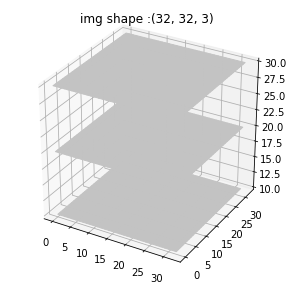

pad_width :  2


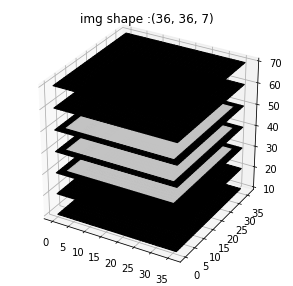

pad_width :  [(2, 0), (0, 0), (0, 0)]


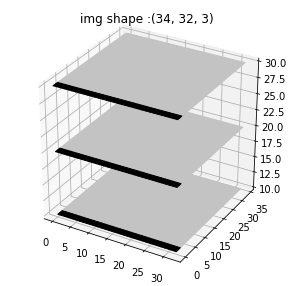

pad_width :  [(0, 0), (2, 2), (0, 0)]


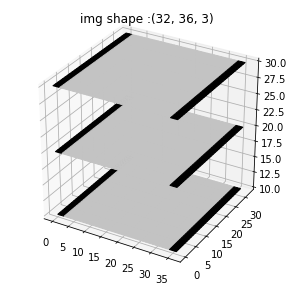

In [3]:
img = 127*np.ones((32,32,3))

print("original img")
img_3Dshow(img)

# 모든 축
pad_width = 2 # [(2,2),(2,2),(2,2)]
padded = np.pad(img,pad_width)
print("pad_width : ",pad_width)
img_3Dshow(padded)

# 한 축, 한쪽
pad_width = [(2,0),(0,0),(0,0)]
padded = np.pad(img, pad_width)
print("pad_width : ",pad_width)
img_3Dshow(padded)

# 한 축, 양쪽
pad_width = [(0,0),(2,2),(0,0)]
padded = np.pad(img, pad_width)
print("pad_width : ",pad_width)
img_3Dshow(padded)

## stride

stride는 kernel이 이미지를 통과할 때 이동하는 step size를 뜻한다.
step size가 크면 건너뛰는 크기가 커지므로, output size 역시 작아지고, Downsampling과 같은 효과를 지니게 된다.

따라서 Output는 다음과 같은 크기를 가진다.

$ H_{out} = 1 + (H_{input} + 2pad - H_{kernel})/ stride$

$ W_{out} = 1 + (W_{input} + 2pad - W_{kernel})/ stride$


## Foward

foward 과정을 쉽게 이해하기 위해, 가장 하위 레벨부터 분할 해서 생각하기로 한다.

- **1.** 
    convolution 연산은 kernel(W)과 kernel이 지나가는 영역(region_x)의 요소별(element-wise) 곱의 합이다. 따라서 다음과 같은 코드로 구현할 수 있다.
    
```python

out = np.sum(region_x * w)
```
    
    

- **2.** 
    이제 1.의 연산을 한 이미지를 돌아다니며 연산해야 되기 때문에 반복문을 사용해야 한다. 반복 기준은 out의 shape을 기준으로 생각하면 좀 더 쉽게 접근할 수 있다. 동시에, 반복문을 수행할 때의 region_x 의 기준점도 같이 생각해준다.
    
![01.png](img/01.png)

```python
for i in range(HHH):
    for j in range(WWW):
        #convolution
```

![02.png](img/02.png)

```python
for i in range(HHH):
    for j in range(WWW):
        x_region = x[n,
                     :, # chanel
                     i*stride : i*stride+HH
                     j*stride : j*stride+WW ]
    
    
```
---
- **3.**
    위(2.)의 연산은 하나의 image와, 하나의 kernel에 대해서의 연산이였으므로 모든 N개의 이미지와 모든 필터 F에 대해서 연산을 해준다.


![03.png](img/03.png)

```python
for n in range(N):
    for f in range(F):
        for i in range(HHH):
            for j in range(WWW):
                x_region = x[n,
                             :, # chanel
                             i*stride : i*stride+HH
                             j*stride : j*stride+WW ]
                
                out[n,f,i,j] = np.sum(x_region * w[f]) + b[f]
```
---



## conv_foward_navie

In [4]:
def conv_forward_naive(x, w, b, conv_param):
    """
    A naive implementation of the forward pass for a convolutional layer.

    The input consists of N data points, each with C channels, height H and
    width W. We convolve each input with F different filters, where each filter
    spans all C channels and has height HH and width WW.

    Input:
    - x: Input data of shape (N, C, H, W)
    - w: Filter weights of shape (F, C, HH, WW)
    - b: Biases, of shape (F,)
    - conv_param: A dictionary with the following keys:
      - 'stride': The number of pixels between adjacent receptive fields in the
        horizontal and vertical directions.
      - 'pad': The number of pixels that will be used to zero-pad the input. 
        

    During padding, 'pad' zeros should be placed symmetrically (i.e equally on both sides)
    along the height and width axes of the input. Be careful not to modfiy the original
    input x directly.

    Returns a tuple of:
    - out: Output data, of shape (N, F, H', W') where H' and W' are given by
      H' = 1 + (H + 2 * pad - HH) / stride
      W' = 1 + (W + 2 * pad - WW) / stride
    - cache: (x, w, b, conv_param)
    """
    out = None
    ###########################################################################
    # TODO: Implement the convolutional forward pass.                         #
    # Hint: you can use the function np.pad for padding.                      #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    N,C,H,W = x.shape
    F,_,HH,WW = w.shape
    stride = conv_param['stride']
    pad = conv_param['pad']
    
    # out shape (N,F,HHH,WWW)
    HHH = int(1 + (H + 2*pad - HH) // stride)
    WWW = int(1 + (W + 2*pad - WW) // stride)
    out = np.zeros((N,F, HHH, WWW))
    
    # pad channel (N,C,H,W)
    padded_x = np.pad(x, ((0,0),(0,0),(pad,pad),(pad,pad)))

    for n in range(N):
        for f in range(F):
            for i in range(HHH):
                for j in range(WWW):
                    x_region = padded_x[n,
                                        :,
                                        i*stride : i*stride+HH,
                                        j*stride : j*stride+WW]
                    
                    out[n,f,i,j] = np.sum(x_region * w[f]) + b[f]

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = (x, w, b, conv_param)
    return out, cache
    

### Testing Code
```cs231n 2020 assignment2```에 있는 테스트 코드를 그대로 가져왔습니다.

In [5]:
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv_param = {'stride': 2, 'pad': 1}
out, _ = conv_forward_naive(x, w, b, conv_param)
correct_out = np.array([[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]])

# Compare your output to ours; difference should be around e-8
print('Testing conv_forward_naive')
print('difference: ', rel_error(out, correct_out))

Testing conv_forward_naive
difference:  2.2121476417505994e-08


---
# Convolution: Naive backward pass

아래 코드는 `cs231n 2020 assignment2`를 참고하여 작성되었습니다.

![04.png](img/04.png)
O를 계산하기 위한 식은 다음과 같다.

$ O = x_1w_1 + x_2w_2 + x_3w_3 + x_4w_4 + ...$

따라서 x,w에 대한 편미분 값은 다음과 같다.

$ \therefore \frac{\partial O}{\partial x_i} = w_i , \frac{\partial O}{\partial w_i} = x_i$

```python
## code
dx[n,
   :,
   i*stride : i*stride+HH,
   j*stride : j*stride+WW] += w[f] * dout[n,f,i,j]

dw[f] += x_region * dout[n,f,i,j]
```

## conv_backward_naive

In [6]:
def conv_backward_naive(dout, cache):
    """
    A naive implementation of the backward pass for a convolutional layer.

    Inputs:
    - dout: Upstream derivatives.
    - cache: A tuple of (x, w, b, conv_param) as in conv_forward_naive

    Returns a tuple of:
    - dx: Gradient with respect to x
    - dw: Gradient with respect to w
    - db: Gradient with respect to b
    """
    dx, dw, db = None, None, None
    ###########################################################################
    # TODO: Implement the convolutional backward pass.                        #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
    x,w,b,conv_param = cache

    N,C,H,W = x.shape
    F,_,HH,WW = w.shape
    _,_,HHH,WWW = dout.shape

    # assert HHH == int(1 + (H + 2*pad - HH) / stride)
    # assert WWW == int(1 + (W + 2*pad - WW) / stride)

    stride = conv_param['stride']
    pad = conv_param['pad']

    padded_x = np.pad(x, ((0,0),(0,0),(pad,pad),(pad,pad))) # N,C,H+2pad,W+2pad
    dpadded_x = np.zeros(padded_x.shape)
    dw = np.zeros(w.shape) # F,C,HH,WW
    
    # calculate
    db = np.sum(dout , axis=(0,2,3)) # (F,)

    for n in range(N):
        for f in range(F):
            for i in range(HHH):
                for j in range(WWW):
                    x_region = padded_x[n,
                                        :,
                                        i*stride : i*stride+HH,
                                        j*stride : j*stride+WW]

                    dw[f] += x_region * dout[n,f,i,j]
                    dpadded_x[n,:,i*stride:i*stride+HH,j*stride:j*stride+WW] += w[f] * dout[n,f,i,j] 

    dx = dpadded_x[:,:, pad:-pad , pad:-pad]
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx, dw, db

### Testing code

In [7]:
np.random.seed(231)
x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 3, 3, 3)
b = np.random.randn(2,)
dout = np.random.randn(4, 2, 5, 5)
conv_param = {'stride': 1, 'pad': 1}

dx_num = eval_numerical_gradient_array(lambda x: conv_forward_naive(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_forward_naive(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_forward_naive(x, w, b, conv_param)[0], b, dout)

out, cache = conv_forward_naive(x, w, b, conv_param)
dx, dw, db = conv_backward_naive(dout, cache)

# Your errors should be around e-8 or less.
print('Testing conv_backward_naive function')
print('dx error: ', rel_error(dx, dx_num))
print('dw error: ', rel_error(dw, dw_num))
print('db error: ', rel_error(db, db_num))

Testing conv_backward_naive function
dx error:  1.159803161159293e-08
dw error:  2.2471264748452487e-10
db error:  3.37264006649648e-11


---
# Max pooling: Naive forward

아래 코드는 `cs231n 2020 assignment2`를 참고하여 작성되었습니다.

pool할 크기와 stride에 따라 out의 크기가 달라지므로 convolution과 마찬가지로 out에 맞춰서 생각해주면 조금 편하다.

i,j 의 값은 region_x의 max값 하나를 취해서 넣어주면 된다.

모든 N개 이미지에 대해, 모든 C(채널)에 대해 수행해준다.

$ H_{out} = 1 + (H_{in} - pool\_height) / stride $

$ W_{out} = 1 + (W_{in} - pool\_width) / stride $


![05.png](img/05.png)

### max 연산 np.max

max 연산은 numpy의 max 함수를 이용하면 쉽게 구할 수 있다.

[numpy.matrix.max](https://numpy.org/doc/stable/reference/generated/numpy.matrix.max) 참고

In [8]:
x = np.arange(12).reshape((3,4))
x

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [9]:
## 모든 값 중 최대값
np.max(x, axis= None)

11

## max_pool_foward_naive

In [10]:
def max_pool_forward_naive(x, pool_param):
    """
    A naive implementation of the forward pass for a max-pooling layer.

    Inputs:
    - x: Input data, of shape (N, C, H, W)
    - pool_param: dictionary with the following keys:
      - 'pool_height': The height of each pooling region
      - 'pool_width': The width of each pooling region
      - 'stride': The distance between adjacent pooling regions

    No padding is necessary here. Output size is given by 

    Returns a tuple of:
    - out: Output data, of shape (N, C, H', W') where H' and W' are given by
      H' = 1 + (H - pool_height) / stride
      W' = 1 + (W - pool_width) / stride
    - cache: (x, pool_param)
    """
    out = None
    ###########################################################################
    # TODO: Implement the max-pooling forward pass                            #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    pool_height = pool_param['pool_height']
    pool_width = pool_param['pool_width']
    stride = pool_param['stride']
    N,C,H,W = x.shape

    HH = int(1 + (H-pool_height)// stride)
    WW = int(1 + (W-pool_height)// stride)

    out = np.zeros((N,C,HH,WW))

    for n in range(N):
        for c in range(C):
            for i in range(HH):
                for j in range(WW):
                    region_x = x[n,
                                 c,
                                 i*stride : i*stride+pool_height,
                                 j*stride : j*stride+pool_width]

                    out[n,c,i,j] = np.max(region_x)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = (x, pool_param)
    return out, cache

### testing

In [11]:
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.3, 0.4, num=np.prod(x_shape)).reshape(x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

out, _ = max_pool_forward_naive(x, pool_param)

correct_out = np.array([[[[-0.26315789, -0.24842105],
                          [-0.20421053, -0.18947368]],
                         [[-0.14526316, -0.13052632],
                          [-0.08631579, -0.07157895]],
                         [[-0.02736842, -0.01263158],
                          [ 0.03157895,  0.04631579]]],
                        [[[ 0.09052632,  0.10526316],
                          [ 0.14947368,  0.16421053]],
                         [[ 0.20842105,  0.22315789],
                          [ 0.26736842,  0.28210526]],
                         [[ 0.32631579,  0.34105263],
                          [ 0.38526316,  0.4       ]]]])

# Compare your output with ours. Difference should be on the order of e-8.
print('Testing max_pool_forward_naive function:')
print('difference: ', rel_error(out, correct_out))

Testing max_pool_forward_naive function:
difference:  4.1666665157267834e-08


---
# Max pooling: Naive backward

아래 코드는 `cs231n 2020 assignment2`를 참고하여 작성되었습니다.

![06.png](img/06.png)

### max값 위치를 찾는 법 1. np.argmax

[numpy.argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) 참고

In [12]:
x = np.arange(12).reshape(3,4)
x

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [13]:
np.argmax(x)
# vectorize 되어 index를 준다.

11

In [14]:
np.unravel_index(np.argmax(x), x.shape)
# row, col 값을 알 수 있다.

(2, 3)

### max 값 위치 찾는 법 2. masking 방법

In [15]:
x

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [16]:
x==np.max(x) # x==11

array([[False, False, False, False],
       [False, False, False, False],
       [False, False, False,  True]])

In [17]:
dx = np.zeros(x.shape)
print(dx)

print('-------------------------------')
dx[x==np.max(x)]=999
print(dx)


[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
-------------------------------
[[  0.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  0.   0.   0. 999.]]


## max_pool_backward_naive

In [18]:
def max_pool_backward_naive(dout, cache):
    """
    A naive implementation of the backward pass for a max-pooling layer.

    Inputs:
    - dout: Upstream derivatives
    - cache: A tuple of (x, pool_param) as in the forward pass.

    Returns:
    - dx: Gradient with respect to x
    """
    dx = None
    ###########################################################################
    # TODO: Implement the max-pooling backward pass                           #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    x, pool_param = cache
    pool_height = pool_param['pool_height']
    pool_width = pool_param['pool_width']
    stride = pool_param['stride']
    N,C,H,W = x.shape
    _,_,HH,WW = dout.shape

    assert HH == int(1+(H-pool_height)//stride),"HH 값 다름."
    assert WW == int(1+(W-pool_height)//stride),"WW 값 다름."

    dx = np.zeros(x.shape)
    for n in range(N):
        for c in range(C):
            for i in range(HH):
                for j in range(WW):
                    region_x = x[n,
                                 c,
                                 i*stride:i*stride+pool_height,
                                 j*stride:j*stride+pool_width]

                    row,col = np.unravel_index(np.argmax(region_x, axis=None),region_x.shape)
                    dx[n,c, i*stride + row, j*stride + col] = dout[n,c,i,j]                   

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx

### Testing

In [19]:
np.random.seed(231)
x = np.random.randn(3, 2, 8, 8)
dout = np.random.randn(3, 2, 4, 4)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num = eval_numerical_gradient_array(lambda x: max_pool_forward_naive(x, pool_param)[0], x, dout)

out, cache = max_pool_forward_naive(x, pool_param)
dx = max_pool_backward_naive(dout, cache)

# Your error should be on the order of e-12
print('Testing max_pool_backward_naive function:')
print('dx error: ', rel_error(dx, dx_num))

Testing max_pool_backward_naive function:
dx error:  3.27562514223145e-12


---
# 3 layers convolution model

conv - relu - 2x2 max pool - affine - relu - affine - softmax

로 이루어진 3층 모델 구현

### Affine(fully connected)


In [20]:
def affine_forward(x, w, b):
    
    out = None
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    N = x.shape[0] 

    flatten_x = x.reshape(N,-1) # flatten a tensor. Shape : (N,D)
    out = np.dot(flatten_x, w) + b
    
    ###########################################################################
    cache = (x, w, b)
    return out, cache


def affine_backward(dout, cache):
    x, w, b = cache
    dx, dw, db = None, None, None
    ###########################################################################
    N = x.shape[0]

    db = np.sum(dout,axis=0) # shallow copy를 방지하기 위해 copy 함수로 복사해주었습니다.
    dx = np.dot(dout,w.T).reshape(x.shape)
    flatten_x = x.reshape(N,-1)
    dw = np.dot(flatten_x.T,dout)
    ###########################################################################
    
    return dx, dw, db

### relu

In [21]:
def relu_forward(x):
    out = None
    ###########################################################################
    out = np.maximum(0,x)
    cache = x
    ###########################################################################
    return out, cache


def relu_backward(dout, cache):
    dx, x = None, cache
    ###########################################################################
    dx = dout
    dx[x<=0] = 0
    ###########################################################################
    return dx

### Softmax

In [22]:
def softmax_loss(x, y):
    shifted_logits = x - np.max(x, axis=1, keepdims=True)
    Z = np.sum(np.exp(shifted_logits), axis=1, keepdims=True)
    log_probs = shifted_logits - np.log(Z)
    probs = np.exp(log_probs)
    N = x.shape[0]
    loss = -np.sum(log_probs[np.arange(N), y]) / N
    dx = probs.copy()
    dx[np.arange(N), y] -= 1
    dx /= N
    return loss, dx

## ThreeLayerConvNet

In [23]:
class ThreeLayerConvNet(object):
    """
    A three-layer convolutional network with the following architecture:

    conv - relu - 2x2 max pool - affine - relu - affine - softmax

    The network operates on minibatches of data that have shape (N, C, H, W)
    consisting of N images, each with height H and width W and with C input
    channels.
    """

    def __init__(
        self,
        input_dim=(3, 32, 32),
        num_filters=32,
        filter_size=7,
        hidden_dim=100,
        num_classes=10,
        weight_scale=1e-3,
        reg=0.0,
        dtype=np.float32,
    ):
        """
        Initialize a new network.

        Inputs:
        - input_dim: Tuple (C, H, W) giving size of input data
        - num_filters: Number of filters to use in the convolutional layer
        - filter_size: Width/height of filters to use in the convolutional layer
        - hidden_dim: Number of units to use in the fully-connected hidden layer
        - num_classes: Number of scores to produce from the final affine layer.
        - weight_scale: Scalar giving standard deviation for random initialization
          of weights.
        - reg: Scalar giving L2 regularization strength
        - dtype: numpy datatype to use for computation.
        """
        self.params = {}
        self.reg = reg
        self.dtype = dtype

        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        #conv
        W1 = np.random.normal(loc=0.0, scale=weight_scale, size=(num_filters, input_dim[0], filter_size, filter_size))
        b1 = np.zeros((num_filters,))
        
        # affine1
        W2_size = (( (input_dim[1]//2) * (input_dim[2]//2) * num_filters), hidden_dim)
        W2 = np.random.normal(loc=0.0, scale=weight_scale, size=(W2_size))
        b2 = np.zeros((hidden_dim,))
        
        # affine2
        W3 = np.random.normal(loc=0.0, scale=weight_scale, size=(hidden_dim, num_classes))
        b3 = np.zeros((num_classes,))
        
        self.params['W1'] = W1
        self.params['b1'] = b1
        self.params['W2'] = W2
        self.params['b2'] = b2
        self.params['W3'] = W3
        self.params['b3'] = b3
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        

        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)

    def loss(self, X, y=None):
        """
        Evaluate loss and gradient for the three-layer convolutional network.

        Input / output: Same API as TwoLayerNet in fc_net.py.
        """
        W1, b1 = self.params["W1"], self.params["b1"]
        W2, b2 = self.params["W2"], self.params["b2"]
        W3, b3 = self.params["W3"], self.params["b3"]

        # pass conv_param to the forward pass for the convolutional layer
        # Padding and stride chosen to preserve the input spatial size
        filter_size = W1.shape[2]
        conv_param = {"stride": 1, "pad": (filter_size - 1) // 2}

        # pass pool_param to the forward pass for the max-pooling layer
        pool_param = {"pool_height": 2, "pool_width": 2, "stride": 2}

        scores = None
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        '''
            conv - relu - 2x2 max pool - affine - relu - affine - softmax
        '''
        
        out1, cache1 = conv_forward_naive(X, W1, b1, conv_param)
        out2, cache2 = relu_forward(out1)
        out3, cache3 = max_pool_forward_naive(out2, pool_param)
        out4, cache4 = affine_forward(out3, W2, b2)
        out5, cache5 = relu_forward(out4)
        scores, cache6 = affine_forward(out5, W3, b3)
        

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################

        if y is None:
            return scores

        loss, grads = 0, {}
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        loss, dout1 = softmax_loss(scores, y)
        loss += self.reg * np.sum(np.square(W1))
        loss += self.reg * np.sum(np.square(W2))
        loss += self.reg * np.sum(np.square(W3))
        
        dout2, dW3, db3 = affine_backward(dout1, cache6)
        dout3 = relu_backward(dout2,cache5)
        dout4, dW2, db2 = affine_backward(dout3, cache4)
        dout5 = max_pool_backward_naive(dout4, cache3)
        dout6 = relu_backward(dout5,cache2)
        _ , dW1, db1 = conv_backward_naive(dout6, cache1)
        
        dW1 += 2 * self.reg * W1
        dW2 += 2 * self.reg * W2
        dW3 += 2 * self.reg * W3
        
        grads['W1'] = dW1
        grads['b1'] = db1
        grads['W2'] = dW2
        grads['b2'] = db2
        grads['W3'] = dW3
        grads['b3'] = db3
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        
        return loss, grads


### Testing

조금 많이 느림.

In [24]:
num_inputs = 2
input_dim = (3, 16, 16)
reg = 0.0
num_classes = 10
np.random.seed(231)
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=7,
                          dtype=np.float64);
loss, grads = model.loss(X, y)
# Errors should be small, but correct implementations may have
# relative errors up to the order of e-2
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 1.380104e-04
W2 max relative error: 1.822723e-02
W3 max relative error: 3.064049e-04
b1 max relative error: 3.477652e-05
b2 max relative error: 2.516375e-03
b3 max relative error: 7.945660e-10


# Ref

https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d

https://cs231n.github.io/optimization-2/

https://cs231n.github.io/convolutional-networks/

https://numpy.org/doc/stable/